## Multiple Linear Regression: Doctor's Appointments vs. Attending Diabetes Classes 

#### Import Boiler Plate Modules:

In [1]:
# This line configures matplotlib to show figures embedded in the notebook.
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Data from source U.S. Chronic Disease: https://www.cdc.gov/cdi/index.html

In [2]:
usecols = ['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1' ]

df = pd.read_csv("U.S._Chronic_Disease_Indicators__CDI_.csv", 
                 usecols=usecols, dtype={'DataValue': 'object',})
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,US,United States,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,16.9,...,18.0,Overall,Overall,NaN,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,AL,Alabama,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,13.0,...,14.1,Overall,Overall,"(32.84057112200048, -86.63186076199969)",1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,AK,Alaska,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,18.2,...,20.6,Overall,Overall,"(64.84507995700051, -147.72205903599973)",2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,AZ,Arizona,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.6,...,16.9,Overall,Overall,"(34.865970280000454, -111.76381127699972)",4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,AR,Arkansas,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.0,...,17.2,Overall,Overall,"(34.74865012400045, -92.27449074299966)",5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


#### A lot of info is duplicated between rows, lets pull those out and turn that data into look up tables (we will keep the ID for each table in the df, so we can merge it back)

In [3]:
# Extract location-related attributes into a location table.
dfLocs = df[['LocationAbbr', 'LocationDesc', 'GeoLocation', 'LocationID']]\
            .set_index('LocationID').groupby('LocationID').first()
geoloc = dfLocs['GeoLocation'].str[1:-1].str.split(',', expand = True).astype('float')
geoloc.columns = ['Latitude', 'Longitude']
dfLocs = pd.concat([geoloc, dfLocs], axis = 1).drop('GeoLocation', axis = 1)
dfLocs.head()


,Latitude,Longitude,LocationAbbr,LocationDesc
LocationID,,,,
1,32.840571,-86.631861,AL,Alabama
2,64.845080,-147.722059,AK,Alaska
4,34.865970,-111.763811,AZ,Arizona
5,34.748650,-92.274491,AR,Arkansas
6,37.638640,-121.000000,CA,California


In [4]:
# Extract topic attributes into a topic table.
dfTopics = df[['TopicID', 'Topic']].groupby('TopicID').first()
dfTopics.head()

,Topic
TopicID,
ALC,Alcohol
ART,Arthritis
AST,Asthma
CAN,Cancer
CKD,Chronic Kidney Disease


In [5]:
# Extract question attributes into a question table.
dfQuestions = df[['QuestionID', 'Question']].groupby('QuestionID').first()
dfQuestions.head()

,Question
QuestionID,
ALC10_0,Local authority to regulate alcohol outlet den...
ALC1_1,Alcohol use among youth
ALC1_2,Alcohol use before pregnancy
ALC2_1,Binge drinking prevalence among youth
ALC2_2,Binge drinking prevalence among adults aged >=...


In [6]:
# Extract Stratification attributes into a Stratification table.
dfStrats = df[['StratificationID1', 'Stratification1']].groupby('StratificationID1').first()
dfStrats

,Stratification1
StratificationID1,
AIAN,American Indian or Alaska Native
API,Asian or Pacific Islander
ASN,"Asian, non-Hispanic"
BLK,"Black, non-Hispanic"
GENF,Female
GENM,Male
HIS,Hispanic
MRC,"Multiracial, non-Hispanic"
OTH,"Other, non-Hispanic"


In [7]:
# Extract StratificationCategory attributes into a StratificationCategory table.
dfStratCats = df[['StratificationCategoryID1', 'StratificationCategory1']] \
    .groupby('StratificationCategoryID1').first()
dfStratCats

,StratificationCategory1
StratificationCategoryID1,
GENDER,Gender
OVERALL,Overall
RACE,Race/Ethnicity


In [8]:
# Extract DataValueType attributes into a DataValueType table.
dfDataValueTypes = df[['DataValueTypeID', 'DataValueType', 'DataValueUnit']]\
    .groupby('DataValueTypeID').first()
dfDataValueTypes.head()

,DataValueType,DataValueUnit
DataValueTypeID,,
AgeAdjMean,Age-adjusted Mean,Number
AgeAdjPrev,Age-adjusted Prevalence,%
AgeAdjRate,Age-adjusted Rate,"cases per 10,000"
AgeSexRaceAdjRate,"Adjusted by age, sex, race and ethnicity","cases per 1,000,000"
AvgAnnAgeAdjRate,Average Annual Age-adjusted Rate,"per 100,000"


#### Now that we have "de-melted" the original data, we will drop all of the duplicate columns into a simpler dataframe using ID's and lookup tables

In [9]:
dfData = df.drop(['GeoLocation', 'LocationAbbr', 'LocationDesc', 'Topic', 'Question', 
    'Stratification1', 'StratificationCategory1', 'DataValueType', 'DataValueUnit'], axis=1)
dfData.head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,BRFSS,16.9,16.9,*,50 States + DC: US Median,16.0,18.0,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,BRFSS,13.0,13.0,NaN,NaN,11.9,14.1,1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,BRFSS,18.2,18.2,NaN,NaN,16.0,20.6,2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,BRFSS,15.6,15.6,NaN,NaN,14.3,16.9,4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,BRFSS,15.0,15.0,NaN,NaN,13.0,17.2,5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


## First: A little description of what each variable means in the context of this dataset

### This is the response variable (`y`):

<img src="I10Course.png" title="Indicator 10" />

### These are the predicting variables ($X_1$, $X_2$, and $X_3$):

<img src="I5Podi.png" title="Indicator 5" />

<img src="I7Opto.png" title="Indicator 7" />

#### This data was sparse, lots of missing data so we removed it in the end

<img src="I8Dentist.png" title="Indicator 8" />

### Drilling into Diabetes Topic and Selecting Overall Data for Analysis

In [10]:
dfOverall = dfData[(dfData['TopicID'] == 'DIA') & #Select Diabetes
      (dfData['DataValueTypeID'] == 'CrdPrev') & #Select Crude Prevalence
      (dfData['DataValueAlt']).notnull() & #Remove null values
      (dfData['StratificationCategoryID1'] == "OVERALL")] #Overall includes all demographics
pivot_index = ['TopicID', 'YearStart', 'YearEnd', 'LocationID', 'StratificationID1']
dfOverall = pd.pivot_table(dfOverall, index = pivot_index, columns = 'QuestionID', 
                           values = 'DataValueAlt').reset_index()
dfOverall.tail()

QuestionID,TopicID,YearStart,YearEnd,LocationID,StratificationID1,DIA10_0,DIA11_1,DIA11_2,DIA11_3,DIA12_1,DIA12_2,DIA13_1,DIA13_2,DIA2_1,DIA2_2,DIA3_1,DIA5_0,DIA6_0,DIA7_0,DIA8_0
343,DIA,2016,2016,56,OVR,56.0,NaN,NaN,20.3,42.5,60.2,44.8,81.9,8.3,3.7,NaN,69.0,69.0,66.6,61.2
344,DIA,2016,2016,59,OVR,NaN,NaN,NaN,25.4,48.4,63.1,50.1,80.4,10.5,5.1,NaN,NaN,NaN,NaN,59.4
345,DIA,2016,2016,66,OVR,40.0,NaN,NaN,14.6,38.6,68.4,48.9,56.5,10.0,6.3,NaN,66.3,63.0,50.3,48.0
346,DIA,2016,2016,72,OVR,24.6,NaN,NaN,27.7,29.0,48.0,15.7,32.2,15.3,4.9,NaN,46.1,73.7,60.7,61.4
347,DIA,2016,2016,78,OVR,34.6,NaN,NaN,NaN,17.4,34.4,35.4,45.8,12.7,NaN,NaN,66.2,64.3,56.8,40.5


Now we have one dataframe with all of the demographics and every question in columns, each Row represents the scores to all questions in a given year per State/Territory

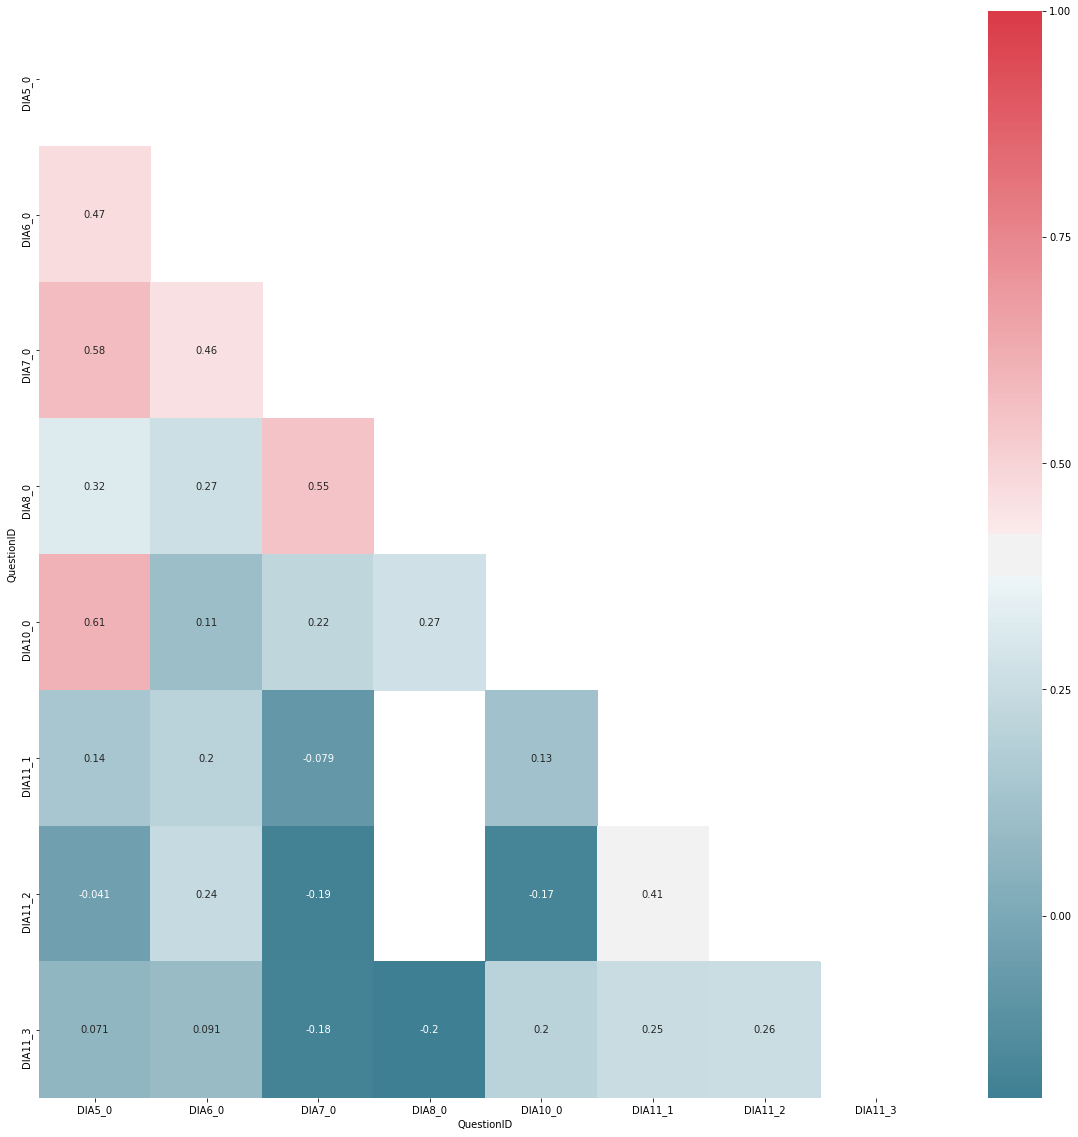

In [11]:
#bring all questions with the same denominator: 18+ with diabetes
dfPatient = dfOverall[['DIA5_0', 'DIA6_0','DIA7_0','DIA8_0','DIA10_0','DIA11_1','DIA11_2','DIA11_3']]
corr = dfPatient.corr(method = 'pearson') 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))     
sns.heatmap(corr, mask=mask, cmap=corr_cmap, annot=True, ax=ax)


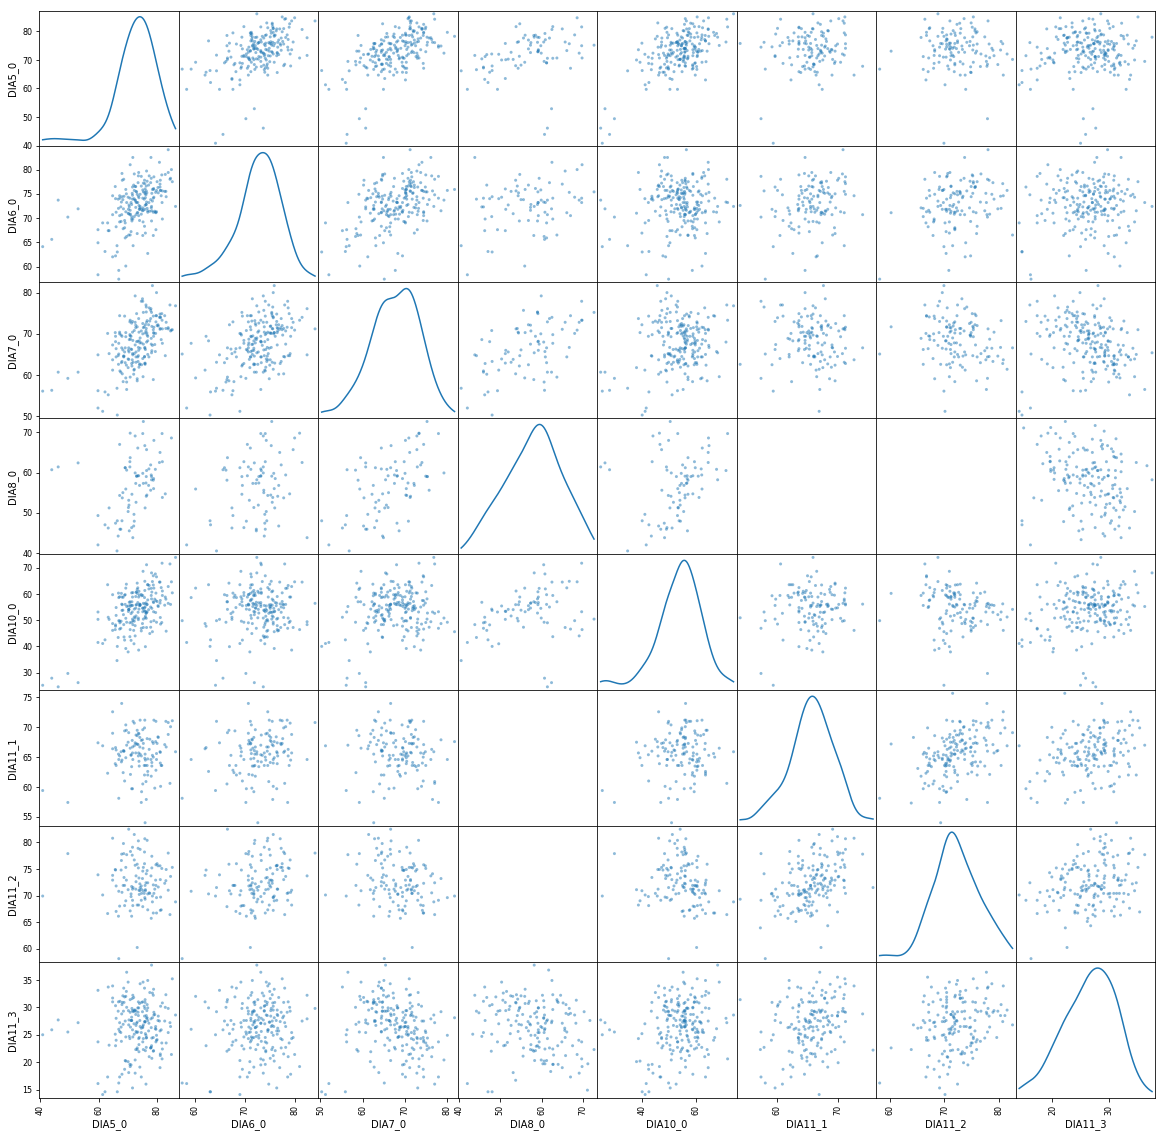

In [12]:
m = pd.plotting.scatter_matrix(dfPatient, figsize=(20,20), diagonal = 'kde')

### Linear Regression Model to Predict Diabetes Class Attendance
We believe that individuals who have lots of health-related appointments would be more likely to attend the Diabetes Class. Or vise versa, they may be seeing more doctors because they went to a life-style changing course (Diabetes class).  

In [13]:
predictors = ['DIA5_0', 'DIA7_0']#, 'DIA8_0'] tried to add DIA 8, but it dropped sample size 
                                #to about 1/4 ~ 1/5 due to missing Data
response = 'DIA10_0'
dfNoNaN = dfPatient[predictors + [response]].dropna()
X = dfNoNaN[predictors]
y = dfNoNaN[response]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
# Print y-intercept (beta_0)
beta_0 = lr.intercept_
print("Beta_0 (y-intercept) for %s linear regression model is %f" % (response, beta_0))
for N in range(len(predictors)):
    beta_N = lr.coef_[N]
    print("Beta_%d (slope) for %s is %f" %(N+1, predictors[N], beta_N))
y_pred = lr.predict(X_test)
lrModel_score = r2_score(y_test, y_pred)
print ("R^2 score for %s linear regression model is %f" % (response, lrModel_score))
print("Keep in mind that dfNoNaN's shape is:", dfNoNaN.shape)
print("Compared to dfPatient, which is:", dfPatient.shape)
dfNoNaN.head()


Beta_0 (y-intercept) for DIA10_0 linear regression model is 15.479459
Beta_1 (slope) for DIA5_0 is 0.793217
Beta_2 (slope) for DIA7_0 is -0.281028
R^2 score for DIA10_0 linear regression model is 0.445464
Keep in mind that dfNoNaN's shape is: (203, 3)
Compared to dfPatient, which is: (348, 8)


QuestionID,DIA5_0,DIA7_0,DIA10_0
23,67.8,66.6,56.1
24,76.7,68.3,63.5
25,71.0,66.3,52.5
26,59.7,64.9,50.3
27,67.9,69.4,58.8


### Conclusion: 
We believe that the attendance to Diabetes Classes and multiple health-related appointments may be related to socioeconomic status and would be an interesting area of study. As we can see from the $R^2$ score, there is a relationship between seeing doctors and the frequency of attendance in classes. Future analysis will delve into the Stratification Categories of Race and Gender within attendance and/or doctor's appointments. 